# Context

After training the model from scratch, we decided it would be better to train a separate model for each phylum. We also opted to use pretrained models. In this notebook, we aim to identify the best-performing pretrained model.

- We compare the models based on their performance on the majority class phylum.
- The same preprocessing steps and model pipeline were used for each model to ensure a fair comparison.


# Imports

In [1]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/rare_species 1.zip'
extract_path = '/content/rare_species 1'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, Xception, DenseNet121
from tensorflow.keras.layers import Rescaling, RandAugment

from sklearn.metrics import classification_report

In [3]:
# With colab
folder_path = '/content/rare_species 1/rare_species 1'
meta = pd.read_csv('/content/rare_species 1/rare_species 1/metadata.csv')

# With vscode
# folder_path = '../data/rare_species 1'
# meta = pd.read_csv('../data/rare_species 1/metadata.csv')

# Phylum Splits

This code splits the species into separate folders based on their phylum.  
This organization allows us to train a dedicated model for each phylum more effectively.


# Splits

In [ ]:

image_size = (224, 224)
seed = 42
batch_size = 32

train_ds, val_ds= keras.utils.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,
    subset= "both",
    seed= seed,
    image_size= image_size,
    batch_size= batch_size
)


Found 951 files belonging to 17 classes.
Using 761 files for training.
Using 190 files for validation.
Found 9952 files belonging to 166 classes.
Using 7962 files for training.
Using 1990 files for validation.
Found 810 files belonging to 13 classes.
Using 648 files for training.
Using 162 files for validation.
Found 210 files belonging to 5 classes.
Using 168 files for training.
Using 42 files for validation.


# Defining the different models

In [7]:
# Model creation functions for different architectures
def make_model_vgg16(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained VGG16 base
    base_model = VGG16(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

def make_model_resnet50(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained ResNet50 base
    base_model = ResNet50(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

def make_model_mobilenetv2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained MobileNetV2 base
    base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

def make_model_xception(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained Xception base
    base_model = Xception(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

def make_model_densenet121(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = RandAugment(value_range= (0, 255))(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained DenseNet121 base
    base_model = DenseNet121(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

# Train and evaluate the models

In [ ]:
def train_and_evaluate_model(model, model_name, train_ds, val_ds, epochs=50):
    """Train and evaluate a model, saving the best version"""

    # Learning rate schedule
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9
    )

    # Callbacks
    checkpoint_path = f"best_model_{model_name}.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            save_best_only=True,
            monitor="val_acc",
            mode="max",
            verbose=1
        )
    ]

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

    # Train the model
    history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds,
    )

    # Load the best model
    best_model = keras.models.load_model(checkpoint_path)

    # Get predictions
    y_pred_probs = best_model.predict(val_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Get true labels
    y_true = np.concatenate([y for x, y in val_ds], axis=0)

    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    report = classification_report(y_true, y_pred, output_dict=True)
    print(classification_report(y_true, y_pred))

    # Return metrics and paths
    return {
        'model_name': model_name,
        'history': history.history,
        'accuracy': report['accuracy'],
        'f1_macro': report['macro avg']['f1-score'],
        'f1_weighted': report['weighted avg']['f1-score'],
        'model_path': checkpoint_path
    }

def compare_models(results):
    """Compare results from multiple models"""

    # Create comparison DataFrame
    comparison = pd.DataFrame([
        {'Model': r['model_name'],
         'Accuracy': r['accuracy'],
         'F1 (Macro)': r['f1_macro'],
         'F1 (Weighted)': r['f1_weighted']}
        for r in results
    ])

    # Sort by accuracy
    comparison = comparison.sort_values('Accuracy', ascending=False)

    # Print results
    print(f"\n=== Model Comparison ===")
    print(comparison)

    # Create visualization
    plt.figure(figsize=(12, 6))

    # Plot accuracy comparison
    plt.subplot(1, 2, 1)
    plt.bar(comparison['Model'], comparison['Accuracy'])
    plt.title('Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # Plot F1 comparison
    plt.subplot(1, 2, 2)
    plt.bar(comparison['Model'], comparison['F1 (Weighted)'])
    plt.title('F1 Score (Weighted) Comparison')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    # Print best model
    best_model = comparison.iloc[0]
    print(f"\nBest model for: {best_model['Model']}")
    print(f"Accuracy: {best_model['Accuracy']:.4f}")
    print(f"F1 Score (Weighted): {best_model['F1 (Weighted)']:.4f}")

    return comparison

# Function to plot learning curves
def plot_learning_curves(results):
    """Plot learning curves for all models"""

    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for result in results:
        plt.plot(result['history']['acc'], label=f"{result['model_name']} (Train)")
        plt.plot(result['history']['val_acc'], label=f"{result['model_name']} (Val)", linestyle='--')

    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    for result in results:
        plt.plot(result['history']['loss'], label=f"{result['model_name']} (Train)")
        plt.plot(result['history']['val_loss'], label=f"{result['model_name']} (Val)", linestyle='--')

    plt.title(f'Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'learning_curves.png')
    plt.show()

# Model run

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<ipython-input-7-9ae534af768a>:48: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

=== Training VGG16 on chordata dataset ===
Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - acc: 0.1276 - loss: 6.0171
Epoch 1: val_acc improved from -inf to 0.23216, saving model to best_model_vgg16.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 176s 672ms/step - acc: 0.1278 - loss: 6.0142 - val_acc: 0.2322 - val_loss: 4.5911
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - acc: 0.7532 - loss: 1.0246
Epoch 2: val_acc improved from 0.23216 to 0.29497, saving model to best_model_vgg16.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 192s 662ms/step - acc: 0.7531 - loss: 1.0250 - val_acc: 0.2950 - val_loss: 4.0618
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - acc: 0.8843 - loss: 0.4418
Epoch 3: val_acc improved from 0.29497 to 0.32513, saving model to best_model_vgg16.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 191s 619ms/step - acc: 0.8843 - loss: 0.4418 - val_acc: 0.3251 - val_loss: 3.8321
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - acc: 0.0237 - loss: 21.7339
Epoch 1: val_acc improved from -inf to 0.06080, saving model to best_model_resnet50.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 186s 689ms/step - acc: 0.0238 - loss: 21.7127 - val_acc: 0.0608 - val_loss: 11.4621
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - acc: 0.0698 - loss: 10.6672
Epoch 2: val_acc did not improve from 0.06080
249/249 ━━━━━━━━━━━━━━━━━━━━ 178s 616ms/step - acc: 0.0698 - loss: 10.6686 - val_acc: 0.0477 - val_loss: 12.3808
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - acc: 0.1006 - loss: 10.4081
Epoch 3: val_acc improved from 0.06080 to 0.07940, saving model to best_model_resnet50.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 207s 637ms/step - acc: 0.1006 - loss: 10.4088 - val_acc: 0.0794 - val_loss: 11.4431
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - acc: 0.1315 - loss: 10.0489
Epoch 4: val_acc did not improve from 0.07940
249/249 ━━━━━━━━━━━━━━━━━━━━ 212s 676ms/step - acc: 0.1315 - 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - acc: 0.0937 - loss: 31.0511
Epoch 1: val_acc improved from -inf to 0.22211, saving model to best_model_mobilenetv2.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 170s 651ms/step - acc: 0.0939 - loss: 31.0521 - val_acc: 0.2221 - val_loss: 24.7995
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - acc: 0.2196 - loss: 28.3966
Epoch 2: val_acc improved from 0.22211 to 0.26231, saving model to best_model_mobilenetv2.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 200s 653ms/step - acc: 0.2196 - loss: 28.4013 - val_acc: 0.2623 - val_loss: 27.9150
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - acc: 0.2852 - loss: 28.0695
Epoch 3: val_acc improved from 0.26231 to 0.30854, saving model to best_model_mobilenetv2.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 190s 604ms/step - acc: 0.2852 - loss: 28.0709 - val_acc: 0.3085 - val_loss: 28.4433
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - acc: 0.3345 - loss: 26.2244
Epoch 4: val_acc improved from 0.30854 to 0.32462, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

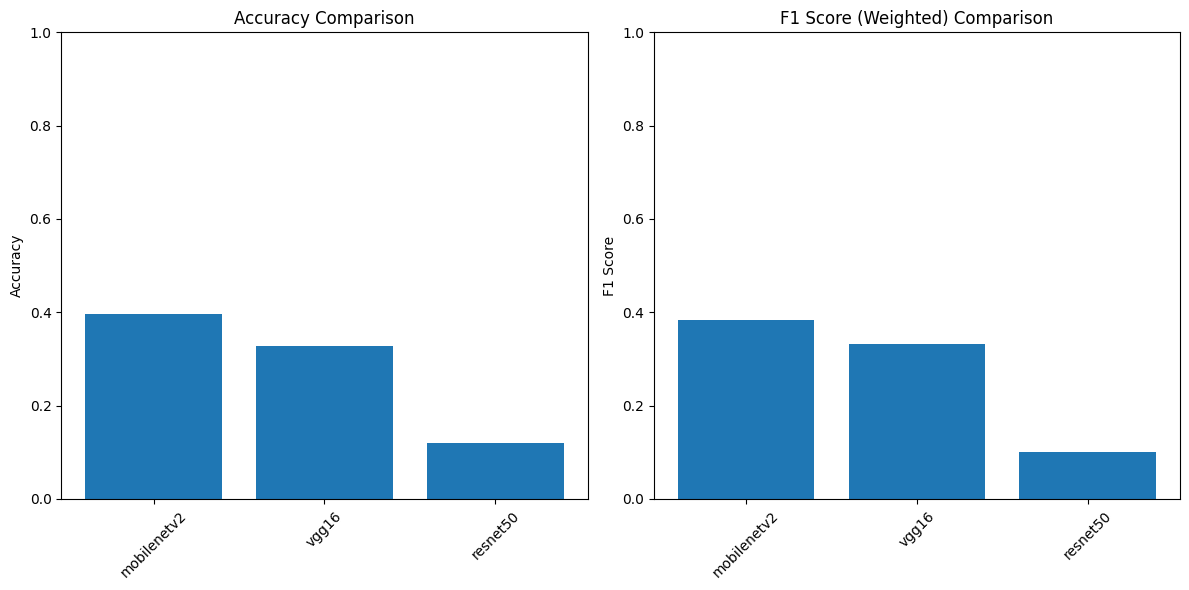


Best model for Chordata: mobilenetv2
Accuracy: 0.3955
F1 Score (Weighted): 0.3843


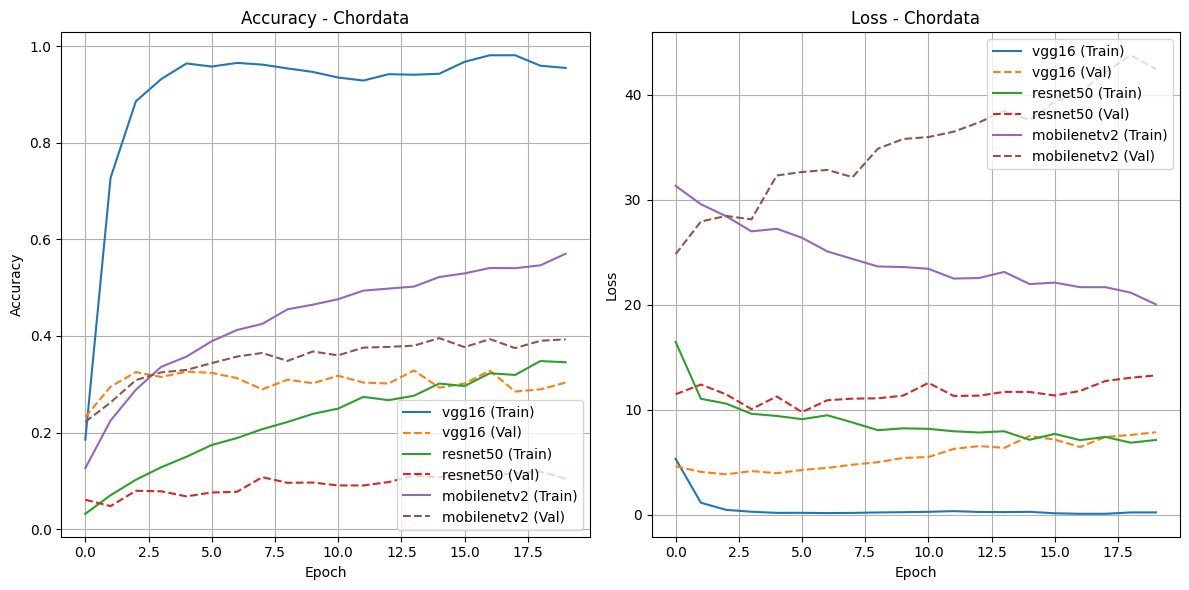

In [ ]:
epochs = 20


model_vgg16 = make_model_vgg16(input_shape=image_size + (3,), num_classes=166)
model_resnet50 = make_model_resnet50(input_shape=image_size + (3,), num_classes=166)
model_mobilenet = make_model_mobilenetv2(input_shape=image_size + (3,), num_classes=166)

# Train and evaluate models
results = []

# Train VGG16
print("\n=== Training VGG16 dataset ===")
result_vgg16 = train_and_evaluate_model(
    model=model_vgg16,
    model_name="vgg16",
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=epochs
)
results.append(result_vgg16)

# Train ResNet50
print("\n=== Training ResNet50 dataset ===")
result_resnet50 = train_and_evaluate_model(
    model=model_resnet50,
    model_name="resnet50",
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=epochs
)
results.append(result_resnet50)

# Train MobileNetV2
print("\n=== Training MobileNetV2 dataset ===")
result_mobilenet = train_and_evaluate_model(
    model=model_mobilenet,
    model_name="mobilenetv2",
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=epochs
)
results.append(result_mobilenet)

# Compare models
compare_models(results)

# Plot learning curves
plot_learning_curves(results)

# Conclusion